Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │          52,326 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,966,182 (11.32 MB)

 Trainable params: 708,198 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 137s 363ms/step - accuracy: 0.3355 - loss: 3.0877 - val_accuracy: 0.8117 - val_loss: 0.7676 - learning_rate: 0.0010
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 126s 351ms/step - accuracy: 0.7635 - loss: 0.8148 - val_accuracy: 0.8584 - val_loss: 0.5040 - learning_rate: 0.0010
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 118s 328ms/step - accuracy: 0.8481 - loss: 0.5340 - val_accuracy: 0.8933 - val_loss: 0.4078 - learning_rate: 0.0010
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 370ms/step - accuracy: 0.8732 - loss: 0.4241 - val_accuracy: 0.9059 - val_loss: 0.3140 - learning_rate: 0.0010
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 312ms/step - accuracy: 0.8918 - loss: 0.3443 - val_accuracy: 0.9024 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 320ms/step - accuracy: 0.9240 - loss: 0.2532 - val_accuracy: 0.9184 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 126s 351ms/step - accura

Test Accuracy: 94.28%
Test Loss: 0.1958


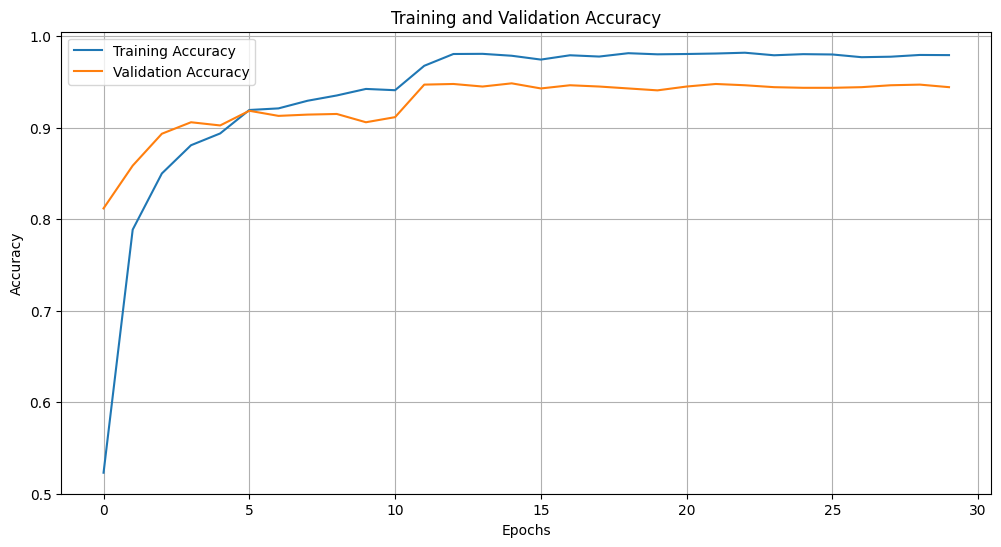

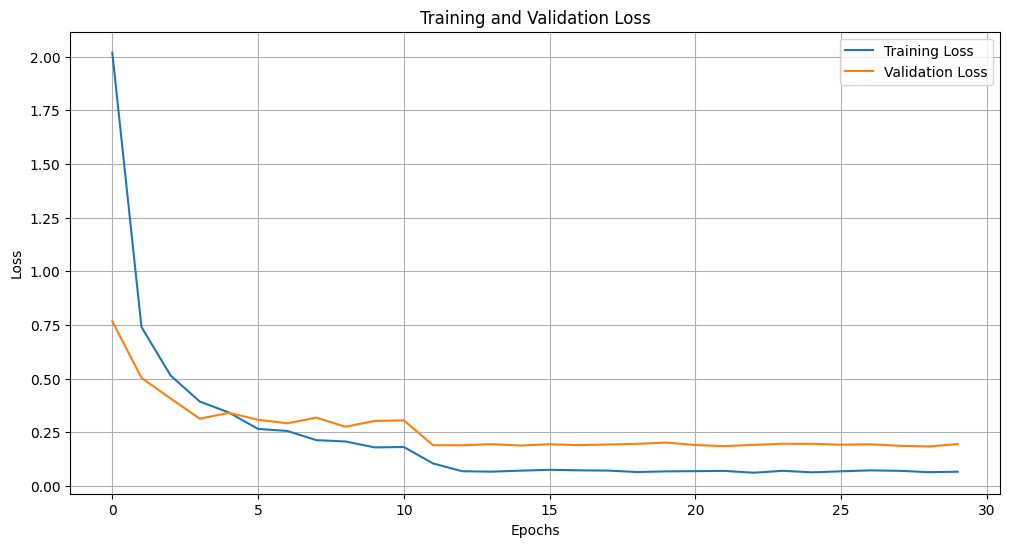

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Load and preprocess the dataset
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
IMG_SIZE = 224  # MobileNetV2 requires 224x224 input size

# Data augmentation using tf.image functions
def augment(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    
    # Simulate random zoom by cropping the image and then resizing it
    zoom_scale = tf.random.uniform([], 0.8, 1.0)
    crop_size = tf.cast(zoom_scale * IMG_SIZE, tf.int32)
    image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize back to original size

    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Preprocessing function for test data (no augmentation)
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Combine both training and test splits into one dataset and shuffle
full_data = dataset['train'].concatenate(dataset['test']).shuffle(buffer_size=1000)

# Split the dataset into 80% training and 20% testing
num_examples = info.splits['train'].num_examples + info.splits['test'].num_examples
train_size = int(0.8 * num_examples)

train_data = full_data.take(train_size)
test_data = full_data.skip(train_size)

# Apply augmentation to the training data and preprocessing to test data
train_data = train_data.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_data = train_data.batch(16).prefetch(tf.data.experimental.AUTOTUNE)  # Reduced batch size
test_data = test_data.map(preprocess).batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# Load the pre-trained MobileNetV2 model, excluding its top classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the convolutional base to prevent training on pre-trained layers
base_model.trainable = False

# Define the new model with MobileNetV2 as the base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global pooling layer to reduce computation
    layers.Dense(512, activation='relu'),  # Add a dense layer with 512 units
    layers.Dropout(0.3),  # Dropout to prevent overfitting
    layers.Dense(102, activation='softmax')  # Output layer for 102 flower species
])

# Compile the model with a slightly higher learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Learning rate schedule: decay the learning rate as training progresses
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

# Train the model with a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Enable mixed precision if your hardware (GPU) supports it
if tf.config.experimental.list_physical_devices('GPU'):
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

# Train the model
history = model.fit(train_data,
                    epochs=30,
                    validation_data=test_data,
                    callbacks=[lr_scheduler])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save the trained model to the specified path
model.save('C:/Users/Sudha/my_trained_model1.h5')  # Save the entire model

# Plot training and validation accuracy over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │          52,326 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,382,580 (16.72 MB)

 Trainable params: 708,198 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1,416,398 (5.40 MB)

In [9]:
# After training, you already have the training history and can print the metrics

# Print final training accuracy and loss
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")

# Print final validation accuracy and loss
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Evaluate the model on the test data and print the results
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Final Training Accuracy: 97.93%
Final Training Loss: 0.0668
Final Validation Accuracy: 94.42%
Final Validation Loss: 0.1955
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.9516 - loss: 0.1522
Test Accuracy: 94.63%
Test Loss: 0.1923


In [10]:
# Load the saved model
model = tf.keras.models.load_model('C:/Users/Sudha/my_trained_model1.h5')

# Now you can use the loaded model to make predictions or continue training


In [11]:
# Load the saved model
model = tf.keras.models.load_model('C:/Users/Sudha/my_trained_model1.h5')

# Recompile the model (optional but recommended to avoid the warning)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Now you can use the loaded model to evaluate or predict


In [12]:
from tensorflow.keras.models import load_model

try:
    model = load_model('C:/Users/Sudha/my_trained_model1.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")


Model loaded successfully.


In [14]:
# Load an example image from the test set
import numpy as np
example_image = test_data.take(2)  # Taking one example from test data
prediction = model.predict(example_image)

print(f"Predicted class: {np.argmax(prediction)}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step
Predicted class: 97


In [25]:
import numpy as np
example_image = test_data.take(102)  # Taking one example from test data
prediction = model.predict(example_image)

print(f"Predicted class: {np.argmax(prediction)}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step
Predicted class: 1179


In [26]:
import tensorflow as tf

# Load the trained model from the saved file
model = tf.keras.models.load_model('C:/Users/Sudha/my_trained_model.h5')

# Inspect the model summary
model.summary()

# Get the number of classes from the output layer
# Assuming the last layer of the model is the output layer and is Dense
output_layer = model.layers[-1]  # Get the last layer of the model
num_classes = output_layer.units  # Get the number of units (which is the number of classes)

# Print the number of classes
print(f"The model was trained to classify {num_classes} classes.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │          52,326 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,966,184 (11.32 MB)

 Trainable params: 708,198 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

The model was trained to classify 102 classes.


In [27]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the dataset and retrieve class names
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# Get class names from the dataset info
class_names = info.features['label'].names

# Load the trained model from the saved file
model = tf.keras.models.load_model('C:/Users/Sudha/my_trained_model1.h5')

# Inspect the model summary
model.summary()

# Get the number of classes from the output layer
output_layer = model.layers[-1]  # Get the last layer of the model
num_classes = output_layer.units  # Get the number of units (number of classes)

# Ensure the number of class names matches the number of classes
if len(class_names) != num_classes:
    print(f"Warning: Number of class names ({len(class_names)}) does not match the number of classes ({num_classes}).")

# Print the class names along with their indices
for i, class_name in enumerate(class_names):
    print(f"Class {i}: {class_name}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │          52,326 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,966,184 (11.32 MB)

 Trainable params: 708,198 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

Class 0: pink primrose
Class 1: hard-leaved pocket orchid
Class 2: canterbury bells
Class 3: sweet pea
Class 4: english marigold
Class 5: tiger lily
Class 6: moon orchid
Class 7: bird of paradise
Class 8: monkshood
Class 9: globe thistle
Class 10: snapdragon
Class 11: colt's foot
Class 12: king protea
Class 13: spear thistle
Class 14: yellow iris
Class 15: globe-flower
Class 16: purple coneflower
Class 17: peruvian lily
Class 18: balloon flower
Class 19: giant white arum lily
Class 20: fire lily
Class 21: pincushion flower
Class 22: fritillary
Class 23: red ginger
Class 24: grape hyacinth
Class 25: corn poppy
Class 26: prince of wales feathers
Class 27: stemless gentian
Class 28: artichoke
Class 29: sweet william
Class 30: carnation
Class 31: garden phlox
Class 32: love in the mist
Class 33: mexican aster
Class 34: alpine sea holly
Class 35: ruby-lipped cattleya
Class 36: cape flower
Class 37: great masterwort
Class 38: siam tulip
Class 39: lenten rose
Class 40: barbeton daisy
Class 41

In [53]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 238ms/step - accuracy: 0.9507 - loss: 0.1827
Test Accuracy: 94.63%
Test Loss: 0.1927


In [28]:
import numpy as np
example_image = test_data.take(100)  # Taking one example from test data
prediction = model.predict(example_image)

print(f"Predicted class: {np.argmax(prediction)}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step
Predicted class: 3644


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


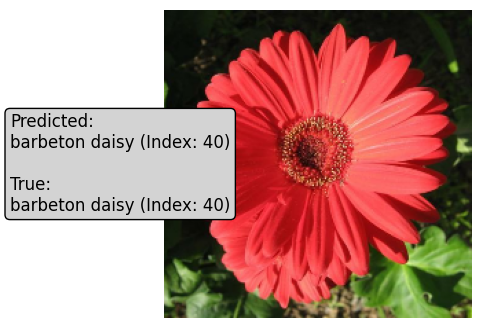

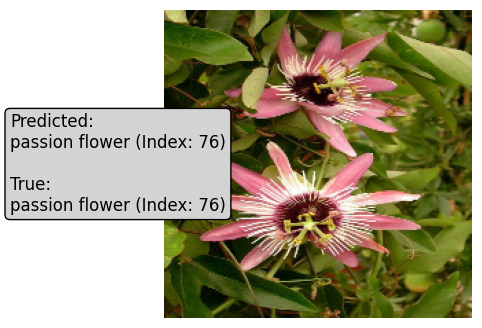

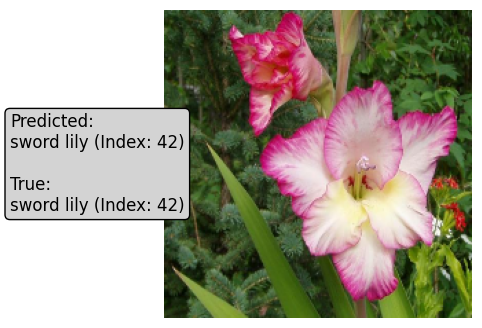

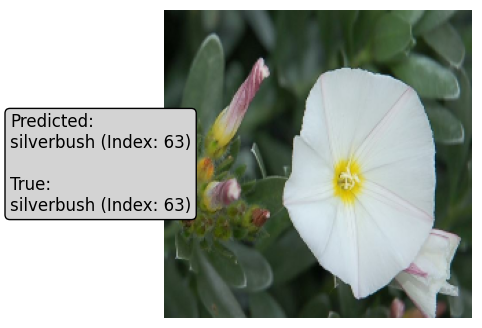

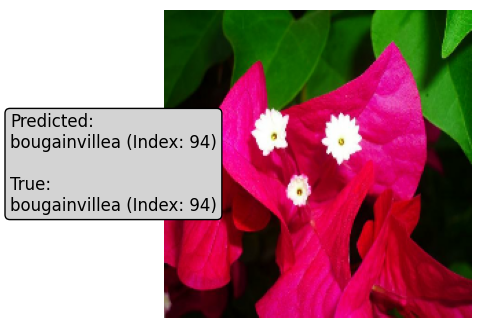

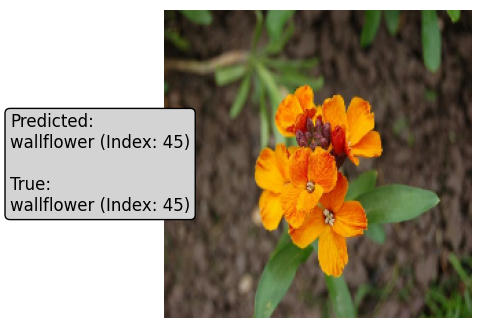

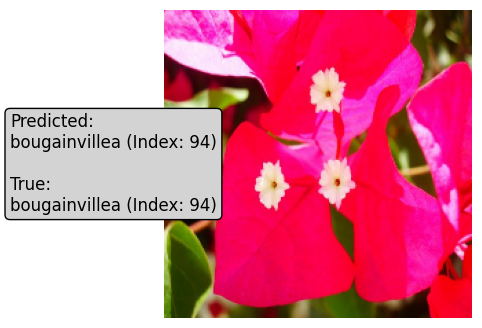

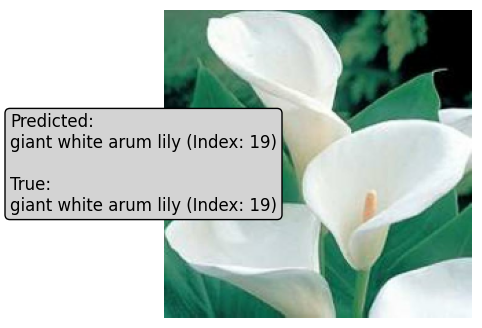

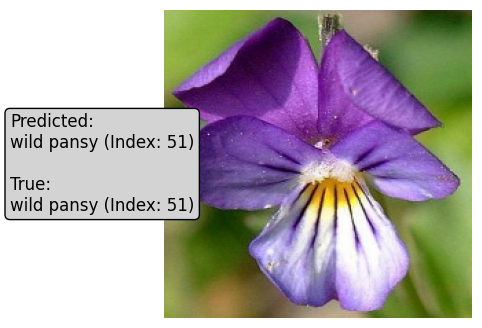

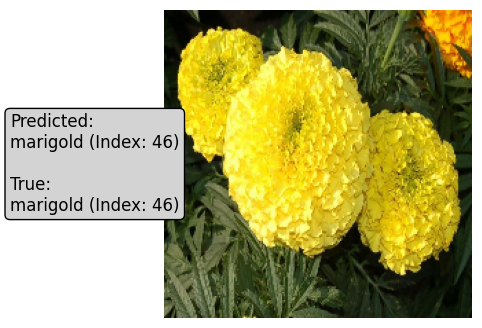

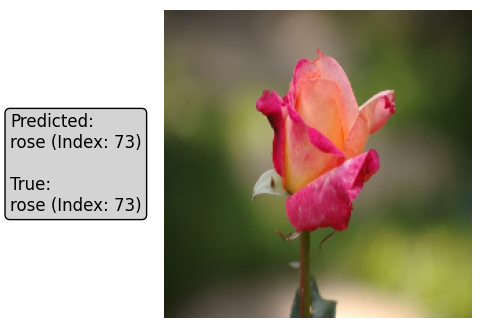

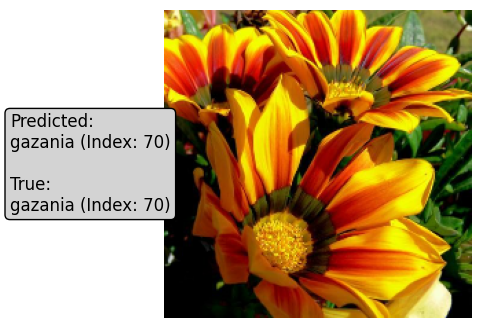

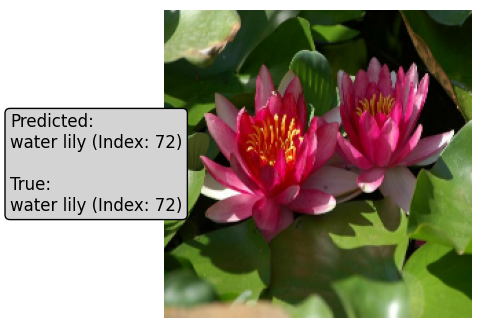

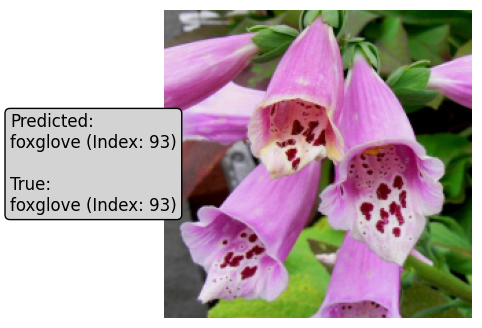

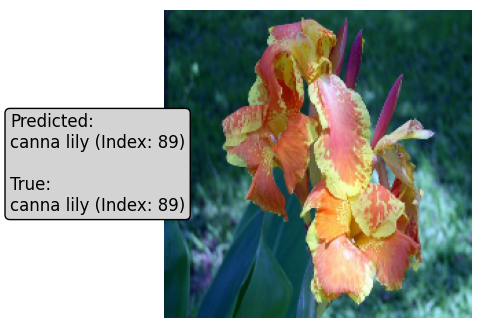

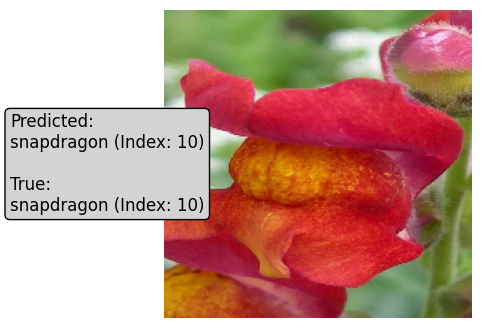

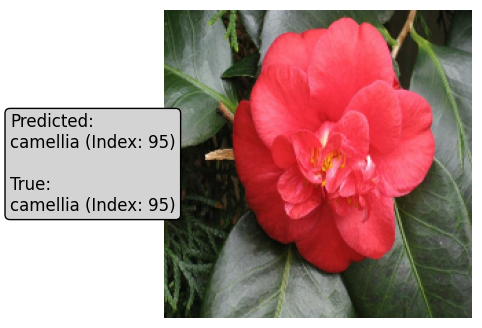

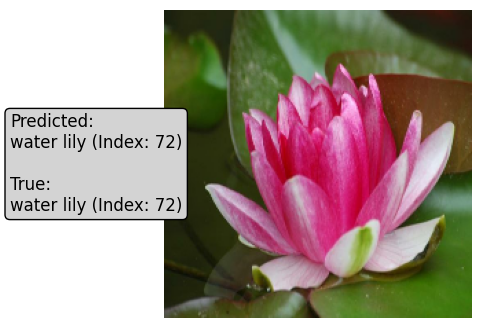

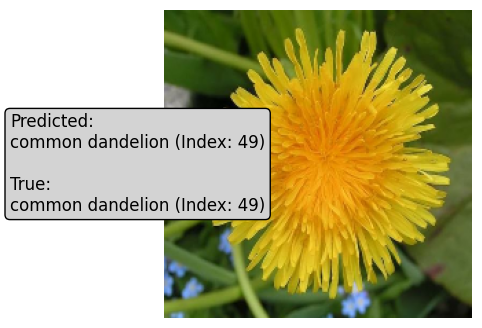

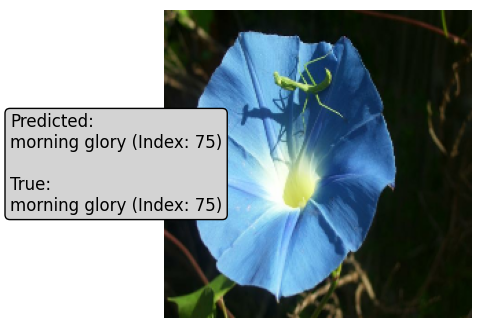

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


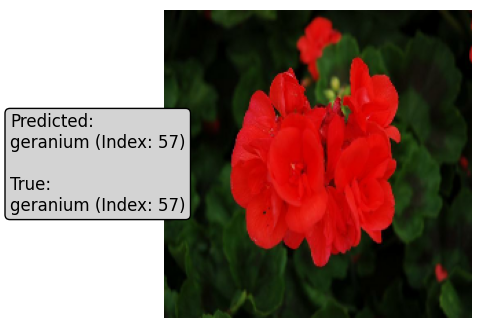

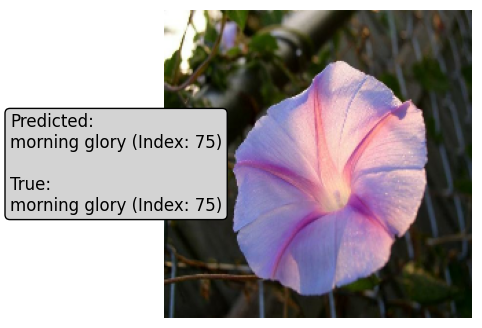

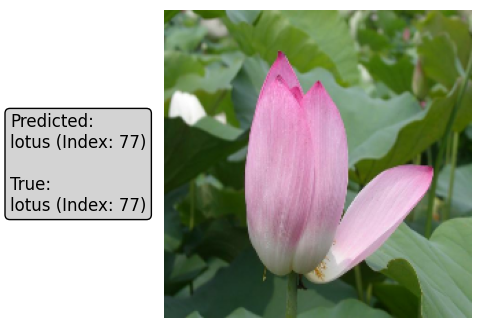

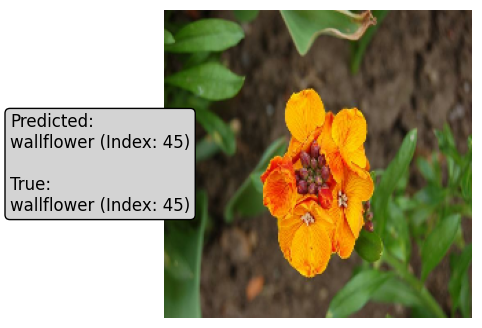

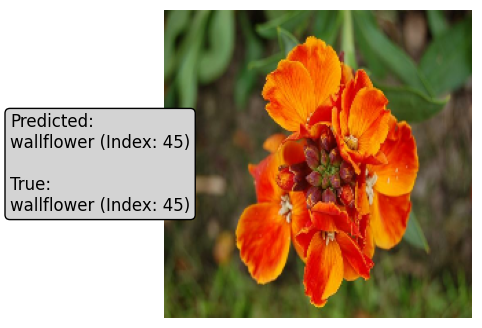

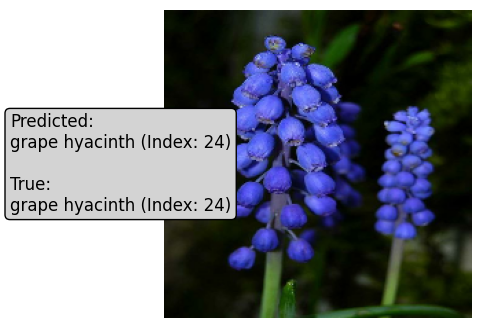

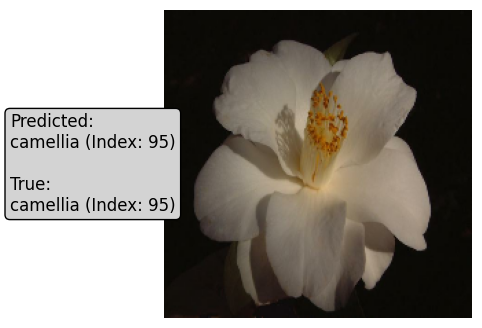

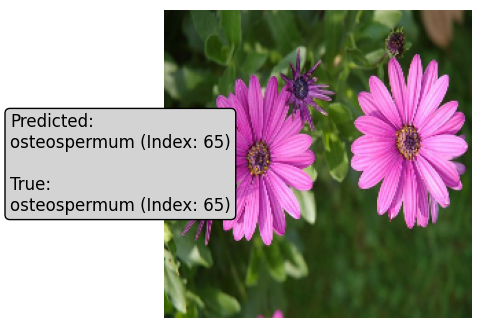

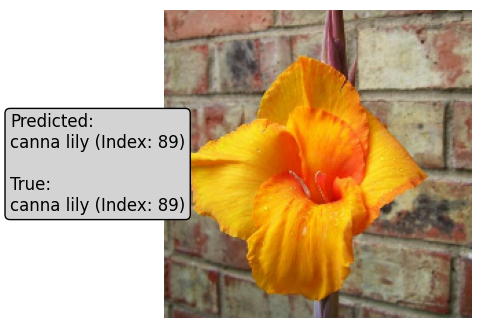

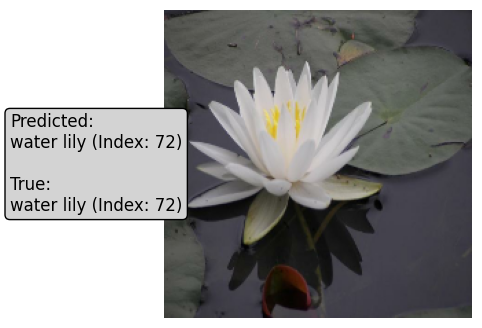

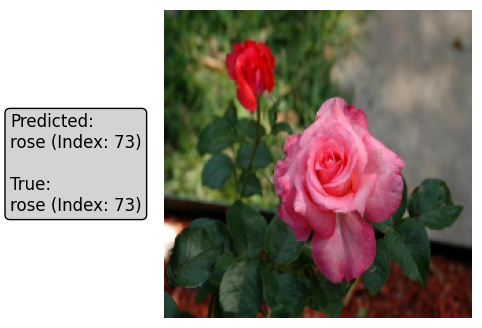

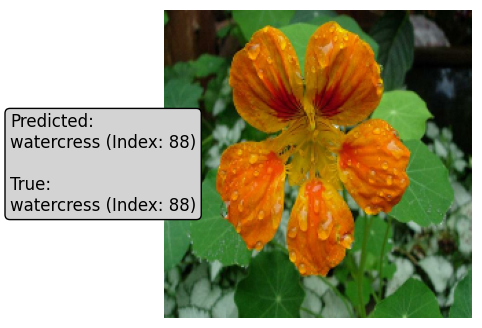

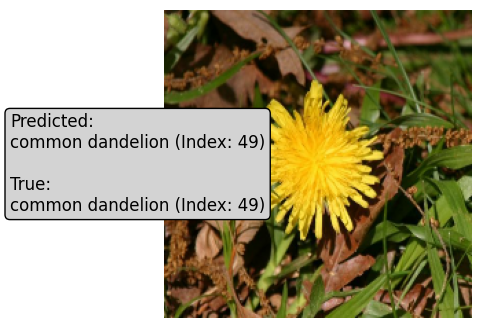

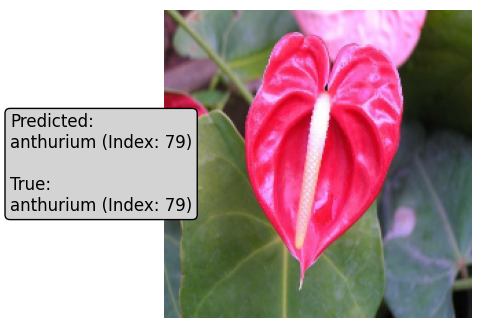

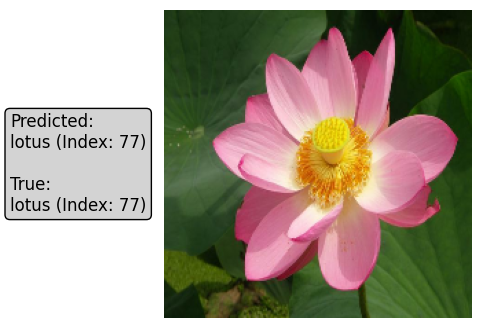

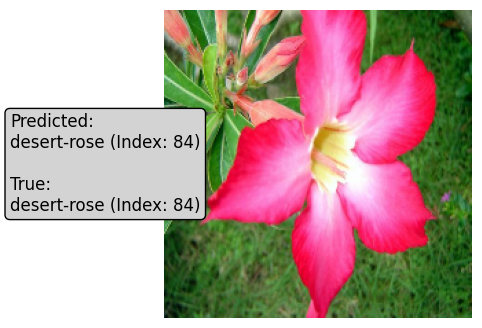

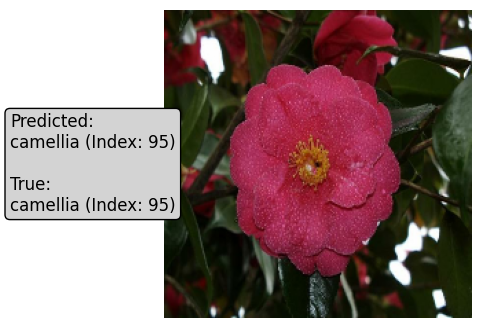

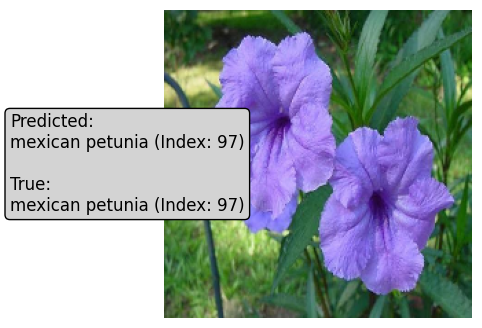

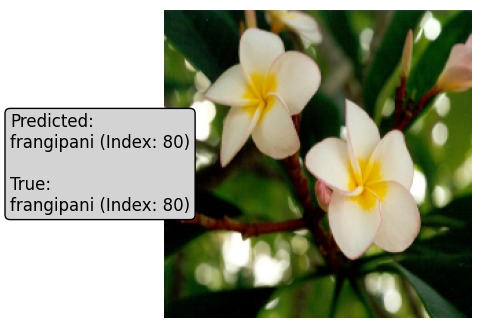

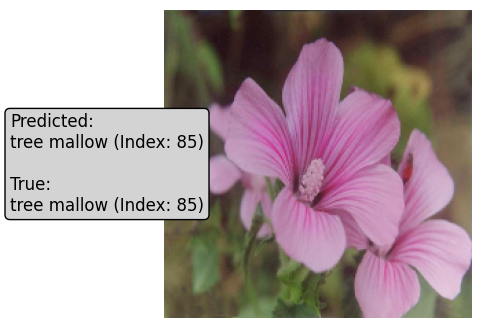

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the dataset and get dataset information
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# Extract class names from dataset info
class_names = info.features['label'].names  # Get the class names dynamically from the dataset metadata

# Define a preprocessing function to resize images
IMG_SIZE = 224  # Model input size

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize image to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply preprocessing to the test dataset
test_data = dataset['test'].map(preprocess_image)

# Take a batch of 2 examples from the preprocessed test dataset
example_batch = test_data.batch(20).take(2)  # Batch size of 2, take 1 batch

# Extract images and labels from the batch
for images, labels in example_batch:
    # Make predictions on the batch
    predictions = model.predict(images)

    # Loop through each image and prediction
    for i in range(len(images)):
        predicted_class = np.argmax(predictions[i])  # Get predicted class index
        true_class = labels[i].numpy()  # Get the true class index
        
        # Get class names for the predicted and true class
        predicted_class_name = class_names[predicted_class]
        true_class_name = class_names[true_class]
        
        # Display the image with labels on the left
        fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the figure size
        
        # Display labels on the left
        details = (
             f"Predicted:\n{predicted_class_name} (Index: {predicted_class})\n\n"
            f"True:\n{true_class_name} (Index: {true_class})"
        )
        plt.text(-0.5, 0.5, details, transform=ax.transAxes, fontsize=12,
                 verticalalignment='center', bbox=dict(boxstyle="round", facecolor="lightgray"))
        
        # Display the image on the right
        ax.imshow(images[i])
        ax.axis('off')
        plt.subplots_adjust(left=0.4, right=0.9)  # Adjust layout to create space for labels
        plt.show()


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have test_data and your trained model

# Get true labels and predictions
y_true = []  # To store true labels
y_pred = []  # To store predicted labels

# Loop through the test dataset and make predictions
for images, labels in test_data:  # Assuming test_data is batched
    predictions = model.predict(images)  # Model predicts probabilities
    predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
    
    y_true.extend(labels.numpy())  # Add true labels
    y_pred.extend(predicted_classes)  # Add predicted labels

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # 'weighted' for imbalanced datasets
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [54]:
import os
print(os.getcwd())


C:\Users\Sudha


In [64]:
#testing code to test my trained model is testing from my saved model or not
from tensorflow.keras.models import load_model

model = load_model('C:/Users/Sudha/my_trained_model1.h5')



In [79]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │          52,326 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,966,184 (11.32 MB)

 Trainable params: 708,198 (2.70 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [80]:
def preprocess_image(image, label):
    IMG_SIZE = 224  # Replace with your model's input size
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    return image, label


In [81]:
predictions = model.predict(images)  # `images` is a batch of preprocessed input data


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


In [82]:
for i in range(len(images)):
    predicted_class = np.argmax(predictions[i])  # Predicted class index
    true_class = labels[i].numpy()  # True class index
    
    print(f"Image {i+1}:")
    print(f"Predicted class index: {predicted_class}, True class index: {true_class}")


Image 1:
Predicted class index: 57, True class index: 57
Image 2:
Predicted class index: 75, True class index: 75
Image 3:
Predicted class index: 77, True class index: 77
Image 4:
Predicted class index: 45, True class index: 45
Image 5:
Predicted class index: 45, True class index: 45
Image 6:
Predicted class index: 24, True class index: 24
Image 7:
Predicted class index: 95, True class index: 95
Image 8:
Predicted class index: 65, True class index: 65
Image 9:
Predicted class index: 89, True class index: 89
Image 10:
Predicted class index: 72, True class index: 72
Image 11:
Predicted class index: 73, True class index: 73
Image 12:
Predicted class index: 88, True class index: 88
Image 13:
Predicted class index: 49, True class index: 49
Image 14:
Predicted class index: 79, True class index: 79
Image 15:
Predicted class index: 77, True class index: 77
Image 16:
Predicted class index: 84, True class index: 84
Image 17:
Predicted class index: 95, True class index: 95
Image 18:
Predicted cla

In [83]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load a single image
image_path = 'sample_flower2.jpg'
image = load_img(image_path, target_size=(224, 224))  # Replace with model input size
image_array = img_to_array(image)  # Convert to NumPy array
image_array = image_array / 255.0  # Normalize
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Predict using the trained model
prediction = model.predict(image_array)
predicted_class = np.argmax(prediction)

# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class]

print(f"Predicted class: {predicted_class_name} (index: {predicted_class})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted class: sunflower (index: 53)


In [88]:
# Test on training data
train_data = dataset['train'].map(preprocess_image)
train_images, train_labels = next(iter(train_data.batch(1)))  # Take a small batch
train_predictions = model.predict(train_images)

for i in range(len(train_images)):
    predicted_class = np.argmax(train_predictions[i])
    true_class = train_labels[i].numpy()
    print(f"Predicted: {class_names[predicted_class]}, True: {class_names[true_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted: water lily, True: water lily


In [85]:
from sklearn.metrics import accuracy_score

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = labels.numpy()

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted class: sunflower (index: 53)


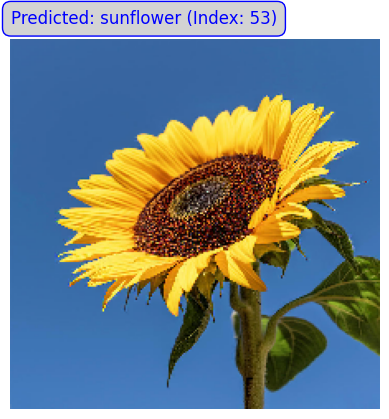

In [89]:
#code to display the given image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load a single image
image_path = 'sample_flower2.jpg'  # Replace with the actual path to your test image
image = load_img(image_path, target_size=(224, 224))  # Resize to model input size
image_array = img_to_array(image)  # Convert to NumPy array
image_array = image_array / 255.0  # Normalize pixel values
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Predict using the trained model
prediction = model.predict(image_array)
predicted_class = np.argmax(prediction)

# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class]

# Print the predicted class
print(f"Predicted class: {predicted_class_name} (index: {predicted_class})")

# Display the image with prediction
plt.imshow(image)  # Display the original image
plt.axis('off')  # Turn off axis for better display
plt.text(
    0, -10, f"Predicted: {predicted_class_name} (Index: {predicted_class})",
    fontsize=12, color='blue', bbox=dict(facecolor='lightgray', edgecolor='blue', boxstyle='round,pad=0.5')
)
plt.show()
